Using device: cuda
Unique characters: 44
Training Plain RNN Model (without attention)
Plain RNN Epoch 1/20: Train Loss: 2.8618, Val Loss: 2.2864, Val Acc: 0.3502
Plain RNN Epoch 2/20: Train Loss: 2.2006, Val Loss: 1.9352, Val Acc: 0.4852
Plain RNN Epoch 3/20: Train Loss: 1.8559, Val Loss: 1.7766, Val Acc: 0.5232
Plain RNN Epoch 4/20: Train Loss: 1.5634, Val Loss: 1.7666, Val Acc: 0.5274
Plain RNN Epoch 5/20: Train Loss: 1.3367, Val Loss: 1.7145, Val Acc: 0.5359
Plain RNN Epoch 6/20: Train Loss: 1.1408, Val Loss: 1.6906, Val Acc: 0.5401
Plain RNN Epoch 7/20: Train Loss: 0.9630, Val Loss: 1.7211, Val Acc: 0.5527
Plain RNN Epoch 8/20: Train Loss: 0.7948, Val Loss: 1.6874, Val Acc: 0.5949
Plain RNN Epoch 9/20: Train Loss: 0.6615, Val Loss: 1.7467, Val Acc: 0.5485
Plain RNN Epoch 10/20: Train Loss: 0.5541, Val Loss: 1.8182, Val Acc: 0.5696
Plain RNN Epoch 11/20: Train Loss: 0.4583, Val Loss: 1.8762, Val Acc: 0.5781
Plain RNN Epoch 12/20: Train Loss: 0.3645, Val Loss: 1.9161, Val Acc: 0.5612

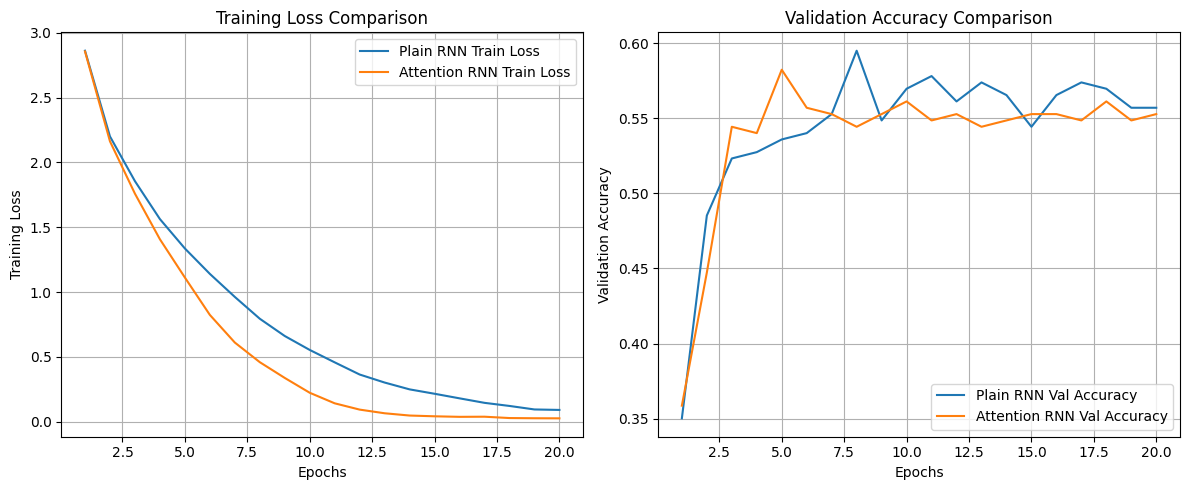

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math
import time
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


#Sample text
text = '''Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in 'memory' about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks. Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each character's appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time. Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants. In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology.'''


# Create character-level vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("Unique characters:", vocab_size)
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for i, ch in enumerate(chars)}

# Dataset that produces input sequences and target character (the next character)
class CharDataset(Dataset):
    def __init__(self, text, seq_length=20):
        self.text = text
        self.seq_length = seq_length
        self.data = [char2idx[ch] for ch in text]

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        # Input sequence of length seq_length and target: the next character
        x = torch.tensor(self.data[idx:idx+self.seq_length], dtype=torch.long)
        y = torch.tensor(self.data[idx+self.seq_length], dtype=torch.long)
        return x, y

# Choose sequence length: try 10, 20, or 30 (here, we use 20)
seq_length = 20
dataset = CharDataset(text, seq_length=seq_length)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)

# Model 1: Plain RNN-based model (using LSTM)
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        # x: (batch, seq_length)
        embedded = self.embedding(x)              # (batch, seq_length, embed_dim)
        output, (hn, cn) = self.lstm(embedded)      # output: (batch, seq_length, hidden_dim)
        # Use the final hidden state for prediction
        out = self.fc(hn[-1])                      # (batch, vocab_size)
        return out

# Model 2: RNN with cross attention.
# After processing the sequence with LSTM, we attend over all time steps using the final hidden state as query.
class RNNWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=1):
        super(RNNWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True)
        # Attention parameters
        self.attn_linear = nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
    
    def forward(self, x):
        # x: (batch, seq_length)
        embedded = self.embedding(x)             # (batch, seq_length, embed_dim)
        outputs, (hn, cn) = self.lstm(embedded)    # outputs: (batch, seq_length, hidden_dim)
        # Use the final hidden state as the query for attention
        query = hn[-1].unsqueeze(1)               # (batch, 1, hidden_dim)
        # Project outputs to get keys
        keys = self.attn_linear(outputs)          # (batch, seq_length, hidden_dim)
        # Compute dot-product attention scores (scaled)
        scores = torch.bmm(query, keys.transpose(1, 2)) / math.sqrt(keys.size(-1))  # (batch, 1, seq_length)
        attn_weights = torch.softmax(scores, dim=-1)  # (batch, 1, seq_length)
        # Compute context vector as weighted sum of outputs
        context = torch.bmm(attn_weights, outputs)  # (batch, 1, hidden_dim)
        context = context.squeeze(1)                # (batch, hidden_dim)
        query = query.squeeze(1)                    # (batch, hidden_dim)
        combined = torch.cat((query, context), dim=1)  # (batch, 2*hidden_dim)
        out = self.fc(combined)                     # (batch, vocab_size)
        return out

# Hyperparameters
embed_dim = 128
hidden_dim = 256
num_layers = 1
learning_rate = 0.003
num_epochs = 20

# Instantiate models
model_plain = RNNModel(vocab_size, embed_dim, hidden_dim, num_layers).to(device)
model_attn = RNNWithAttention(vocab_size, embed_dim, hidden_dim, num_layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_plain = optim.Adam(model_plain.parameters(), lr=learning_rate)
optimizer_attn = optim.Adam(model_attn.parameters(), lr=learning_rate)

# Functions to train and evaluate a model
def train_model(model, optimizer, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)          # logits shape: (batch, vocab_size)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def evaluate_model(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

# Containers for metrics
plain_train_losses = []
plain_val_losses = []
plain_val_accs = []

attn_train_losses = []
attn_val_losses = []
attn_val_accs = []

# Training loop for the plain RNN model
print("Training Plain RNN Model (without attention)")
start_time = time.time()
for epoch in range(num_epochs):
    train_loss = train_model(model_plain, optimizer_plain, train_loader)
    val_loss, val_acc = evaluate_model(model_plain, val_loader)
    plain_train_losses.append(train_loss)
    plain_val_losses.append(val_loss)
    plain_val_accs.append(val_acc)
    print(f"Plain RNN Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
plain_time = time.time() - start_time

# Training loop for the RNN with attention model
print("\nTraining RNN Model with Cross Attention")
start_time = time.time()
for epoch in range(num_epochs):
    train_loss = train_model(model_attn, optimizer_attn, train_loader)
    val_loss, val_acc = evaluate_model(model_attn, val_loader)
    attn_train_losses.append(train_loss)
    attn_val_losses.append(val_loss)
    attn_val_accs.append(val_acc)
    print(f"Attention RNN Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
attn_time = time.time() - start_time

print("\nTiming Summary:")
print(f"Plain RNN training time: {plain_time:.2f} seconds")
print(f"RNN with Attention training time: {attn_time:.2f} seconds")

# Visualization of training loss and validation accuracy
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, plain_train_losses, label='Plain RNN Train Loss')
plt.plot(epochs, attn_train_losses, label='Attention RNN Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, plain_val_accs, label='Plain RNN Val Accuracy')
plt.plot(epochs, attn_val_accs, label='Attention RNN Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
